# Analyzing Slack posts

In [1]:
import os
import re
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import math
#import requests - Slack API is painful with constant 403 requests.  Possible issue of OAuth vs Key
%matplotlib inline

In [2]:
#Specify indir which is the directory of the export data download from Slack
#Creates a list of channels and prints subdirectories with files.
indir = '.\CUDSI_POSTS_6292017'
channels = []

for dirname in os.listdir(indir):
    print '\n', dirname, '\n', '---------------------'
    channels.append(dirname)
    if not dirname.endswith('.json'):
        for filename in os.listdir(indir+"\\"+dirname):
            print filename
        


campus_life 
---------------------
2017-04-10.json
2017-05-02.json
2017-05-06.json
2017-06-01.json
2017-06-07.json
2017-06-08.json
2017-06-09.json
2017-06-10.json
2017-06-11.json
2017-06-12.json
2017-06-13.json
2017-06-14.json
2017-06-15.json
2017-06-17.json
2017-06-18.json
2017-06-19.json
2017-06-21.json
2017-06-22.json
2017-06-23.json
2017-06-26.json

channels.json 
---------------------

courses 
---------------------
2017-04-10.json
2017-05-02.json
2017-05-06.json
2017-06-01.json
2017-06-07.json
2017-06-08.json
2017-06-09.json
2017-06-10.json
2017-06-11.json
2017-06-12.json
2017-06-13.json
2017-06-14.json
2017-06-15.json
2017-06-17.json
2017-06-18.json
2017-06-19.json
2017-06-20.json
2017-06-21.json
2017-06-22.json
2017-06-23.json
2017-06-24.json
2017-06-25.json
2017-06-26.json
2017-06-27.json
2017-06-28.json

frequently_asked 
---------------------
2017-03-22.json
2017-04-10.json
2017-05-02.json
2017-05-06.json
2017-06-01.json
2017-06-07.json
2017-06-08.json
2017-06-09.json
2017-

### Reading in files and scraping into pd DataFrame

In [3]:
#Find the user ID's and user-names of all those who have joined the slack general channel
#Should be all users in Slack since everyone is thrown into #general
#There is now a user's json file which wasn't there when this was written

user_id_to_name = {}
for filename in os.listdir(indir+"\\general\\"):
    with open(indir+"\\general\\"+filename, 'r') as jsonfile:
        data = json.load(jsonfile)
       
    for message in data:
        if 'subtype' in message:
            if message['subtype'] == 'channel_join':
                user_id = message['user']
                user_name = re.sub('.+\||>.+', '', message['text'], re.IGNORECASE)
                user_id_to_name[user_id] = user_name
           

In [4]:
#df = pd.DataFrame(columns=['user_id', 'text', 'channel', 'timestamp'])
list_of_messages = []

#Loop over each folder in main data directory
#Each folder represents a different channel
for dirname in os.listdir(indir):
    if dirname.endswith('.json'):
        continue
    #Loop over all files in channel specific folder
    #Each file represents a day
    for filename in os.listdir(indir+"\\"+dirname):
        
        #Open up and read in .json file corresponding to a post
        with open(indir+"\\"+dirname+"\\"+filename, 'r') as jsonfile:
            data = json.load(jsonfile)
        
        #Loop over each message from the .json file.  
        #.json file is a list of dictionaries, each dictionary 
        #corresponding to one post
        for message in data:

            #Ignores 'channel_join' messages
            if 'subtype' in message.keys():
                if message['subtype'] == 'channel_join':
                    continue
                    
            
            current = {'channel' : dirname,
                       'timestamp' : float(message['ts']),
#                       'user_id' : message['user'],
                       'text' : re.sub("<.+>|'", '', message['text'])}
            list_of_messages.append(current)

In [5]:
# Convert lists of dictionaries into pandas dataframe
df = pd.DataFrame(list_of_messages)

#Get the date from the datetime object
def get_date(ts):
    date_time = datetime.datetime.fromtimestamp(ts)
    return date_time.date()

#Get the time from the datetime object
def get_time(ts):
    date_time = datetime.datetime.fromtimestamp(ts)
    return date_time.time().strftime("%H:%M")

#Convert datetime time to a float value for plotting
def time_to_float(t):
    hour_minute = t.split(':')
    return float(hour_minute[0]) + float(hour_minute[1])/60

#Converts channels to ints to be better handled as labels in numpy
channel_to_numeric = {}
for i, channel in enumerate(np.unique(df['channel'])):
    channel_to_numeric[channel] = i

#Apply functions to create new columns
df['date'] = df['timestamp'].apply(get_date)            
df['time'] = df['timestamp'].apply(get_time)
#df['username'] = df['user_id'].apply(lambda x: user_id_to_name[x])  
df['numeric_label'] = df['channel'].apply(lambda x: channel_to_numeric[x])

### Base stats plots showing counts of posts

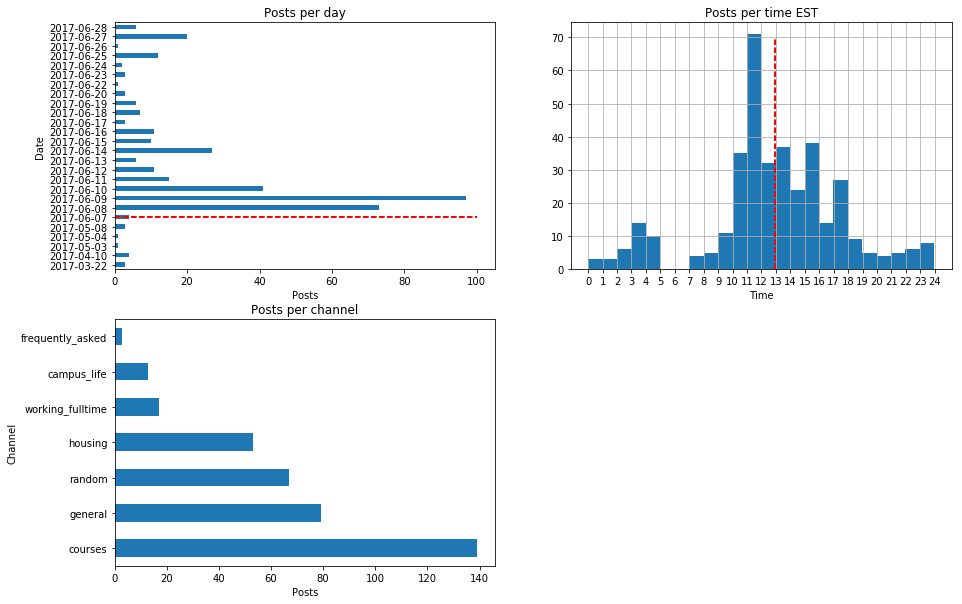

In [6]:
#Initialize Plot
fig = plt.figure(figsize=(15,10))

#First axes in upper left shows number of posts per day in total
#The red line shows the date which the Slack group invited students
axes = fig.add_subplot(2,2,1)
df['date'].value_counts().sort_index().plot(kind = 'barh', title = 'Posts per day', ax = axes)
axes.plot([0,100],[5,5],'r--',lw=2)
axes.set_ylabel('Date')
axes.set_xlabel('Posts')

#Second axes in upper right shows total posts at different times of day
average_time = df['time'].apply(time_to_float).mean()
axes = fig.add_subplot(2,2,2)
df['time'].apply(time_to_float).hist(bins=24, ax= axes)
axes.plot([average_time, average_time], [0,70], 'r--',lw=2)
axes.xaxis.set_ticks(np.arange(0, 25, 1))
axes.set_xlabel('Time')
axes.set_title('Posts per time EST')

#Third axes in lower left shows total posts per channel
axes = fig.add_subplot(2,2,3)
df['channel'].value_counts().plot(kind='barh', title = 'Posts per channel', ax = axes)
axes.set_ylabel('Channel')
axes.set_xlabel('Posts')

plt.show()

In [7]:
#SKLearn imports for NMF, LDA, KMeans and PCA ran on text data.
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
#token_pattern = r"\b\w\w+\b"

### NMF and LDA feature analysis
Fit LDA and NMF models to extract topic groups and their top features.  Each post is treated as a document and the content of each post, words through word counts, are used to determine the topics
* n_components defines the number of components for NMF and number of topics for LDA.  These values relate to the "number of topics" found throughout the documents
$${\ }$$
* top_n_features defines the number of features to print

In [8]:
#Number of components, n_components, for NMF/LDA and number of features to print
#Number of components relates to the number of "topics" found throughout the documents

n_components = 7
top_n_features = 5

#Initialize a word count vectorizer which creates a sparse matrix with 
#documents as rows and words as columns
vectorizer = CountVectorizer(stop_words="english")

#Fit and transform the count vectorizer
X_counts = vectorizer.fit_transform(df['text'])

#Define function to print the top words after NMF/LDA
def print_top_words(model, feature_names, n_top_words):
    print('\n--------------------------------\n')
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % (topic_idx+1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    
#Fit an NMF model
nmf = NMF(n_components=n_components)
nmf.fit(X_counts)
print_top_words(nmf, vectorizer.get_feature_names(),top_n_features)

#Fit an LDA model
lda = LatentDirichletAllocation(n_topics=n_components, learning_method='batch')
lda.fit(X_counts)
print_top_words(lda, vectorizer.get_feature_names(),top_n_features)

print('\n--------------------------------\n')

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
def plot_features(coef, feature_names, top_n=15, ax=None, title=None):
    """
    Parameters
    ----------
    coef            :     array-like, list of coefficients, unsorted
    
    feature_names   :     array-like, list of feature names indexed according to coefficients
    
    top_n           :     int, number of features to print
    
    ax              :     matplotlib axes object, axes to plot on
    
    title           :     string, title to be given to the plot
    
    
    Outputs
    -------
    Creates a bar plot on the specified axis of coefficients and their names.
    If not axis is supplied then a new plot is created.
    """
    
    #Initialize an axis if None is given
    if ax is None:
        return None
        ax = plt.gca()
    
    #Sort to coefficients and take the top_n
    inds = np.argsort(coef)
    high = inds[-top_n:]
    
    #Define a range for the plot
    myrange = range(len(high))
    
    #Plot the bar chart for features
    ax.barh(myrange, coef[high])
    ax.set_yticks(myrange)
    ax.set_yticklabels(feature_names[high])
    ax.yaxis.labelpad=10
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #If a title is given, give the plot a title
    if title:
        ax.set_title(title)

In [ ]:
num_topics = 9

#vectorizer = TfidfVectorizer(stop_words="english")
vectorizer = CountVectorizer(stop_words="english")
X_counts = vectorizer.fit_transform(df['text'])
feature_names = np.array(vectorizer.get_feature_names())   

In [ ]:
nmf = NMF(n_components = num_topics)
nmf.fit(X_counts)
  
components = nmf.components_
n = len(components)

fig, axes = plt.subplots(int(math.ceil(n/3)),3, figsize=(18, 6*int(n/3)))
for component,ax,i in zip(components, axes.flatten(), range(1,num_topics+1)):
    plot_features(component, feature_names, ax=ax, title = 'Topic #%d' %i)

In [ ]:
lda = LatentDirichletAllocation(n_topics=5, learning_method='batch')
lda.fit(X_counts)

components = nmf.components_
n = len(components)

fig, axes = plt.subplots(int(math.ceil(n/3)),3, figsize=(18, 6*int(n/3)))
for component,ax,i in zip(components, axes.flatten(), range(1,num_topics+1)):
    plot_features(component, feature_names, ax=ax, title = 'Topic #%d' %i)

In [ ]:
#Create a new CountVectorizer to capture bigrams
num_topics = 7

#vectorizer = TfidfVectorizer(stop_words="english")
vectorizer = CountVectorizer(stop_words="english", ngram_range=(2,2))
X_counts = vectorizer.fit_transform(df['text'])
feature_names = np.array(vectorizer.get_feature_names())   

In [ ]:
#Graph the top n_components topics for bigrams
nmf = NMF(n_components = num_topics)
nmf.fit(X_counts)
  
components = nmf.components_
n = len(components)

fig, axes = plt.subplots(int(math.ceil(n/3)),3, figsize=(18, 6*int(n/3)))
for component,ax,i in zip(components, axes.flatten(), range(1,num_topics+1)):
    plot_features(component, feature_names, ax=ax, title = 'Topic #%d' %i)

In [ ]:
lda = LatentDirichletAllocation(n_topics=5, learning_method='batch')
lda.fit(X_counts)

components = nmf.components_
n = len(components)

fig, axes = plt.subplots(int(math.ceil(n/3)),3, figsize=(18, 6*int(n/3)))
for component,ax,i in zip(components, axes.flatten(), range(1,num_topics+1)):
    plot_features(component, feature_names, ax=ax, title = 'Topic #%d' %i)

### Clustering analysis using KMeans, LDA and NMF

In [ ]:
#PCA to project data.  Analyze the explained variance
#To ensure first and second components as significant
pca = PCA(n_components=30)
pca.fit(X_counts.toarray())
explained = pca.explained_variance_

fig = plt.figure()
axes = fig.add_subplot(1,1,1)
axes.plot(range(1, len(explained) + 1), explained)
axes.set_ylabel('Explained Variance')
axes.set_xlabel('Principle Component')
plt.show()

In [ ]:
#Run clustering with n_components as number of clusters.
n_components = 7

kmn = KMeans(n_clusters=n_components)
clusters_kmn = kmn.fit_predict(X_counts)

nmf = NMF(n_components = n_components)
nmf.fit(X_counts.T)
clusters_nmf = np.argmax(nmf.components_, axis=0)

lda = LatentDirichletAllocation(n_topics = n_components, learning_method='batch')
lda.fit(X_counts.T)
clusters_lda = np.argmax(lda.components_, axis=0)

In [ ]:
#Project data down to 2D for visualization
pca = PCA(n_components = 2)
projected_data = pca.fit_transform(X_counts.toarray())

#Define list of cluster labels, titles and axes to loop over
clusterings = [df['numeric_label'].as_matrix(), clusters_lda, clusters_nmf, clusters_kmn ]
titles = ['True Labels', 'LDA', 'NMF', 'KMeans']
fig, axes = plt.subplots(2,2, figsize=(15,15))

#Main loop taking indexed list of cluster labels, all axes and titles
#for plotting
for clustering, ax, title in zip(clusterings, axes.flatten(), titles):
    
    #Loop over all unique cluster labels to allow for
    #specific visual attributes per clustering.
    for c in np.unique(clustering):
        ax.scatter(projected_data[c == clustering, 0],
                   projected_data[c == clustering, 1],
                   s=7, label = c, alpha = 0.7)
    
    #Set axis attributes per axis
    ax.legend(bbox_to_anchor=(1.0, 1))
    ax.set_ylim(-0.6,0.2)
    ax.set_xlim(-0.1,0.2)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(title)

plt.show()